https://cs231n.github.io/

In [1]:
#!git clone git@github.com:alexeygrigorev/clothing-dataset-small.git

## 8.2 TensorFlow and Keras

* Installing TensorFlow
* Loading Images

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
from pathlib import Path

In [5]:
from tensorflow.keras.preprocessing.image import load_img

In [6]:
path = './clothing-dataset-small/train/t-shirt/'
name = '00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg'

fullname = Path(path, name)

In [7]:
img = load_img(fullname, target_size=(299,299))

In [8]:
print(img)

<PIL.Image.Image image mode=RGB size=299x299 at 0x12F033D90>


In [9]:
#Turn image to a numpy array

x = np.array(img)
x.shape

(299, 299, 3)

## 8.3 Pre-trainded convolutional neural networks

* Imagenet dataset: https://www.image-net.org
* Pre-trained models: https://keras.io/api/applications/

In [10]:
from tensorflow.keras.applications.xception import Xception
#adding a preprocessing function
from tensorflow.keras.applications.xception import preprocess_input
#adding decoding predictions
from tensorflow.keras.applications.xception import decode_predictions

In [11]:
model = Xception(weights = 'imagenet', input_shape=(299,299,3))

In [12]:
X=np.array([x])
X.shape

(1, 299, 299, 3)

In [13]:
X=preprocess_input(X)

In [14]:
pred = model.predict([X])
pred.shape

/Users/AKhvatov/.local/share/virtualenvs/machine-learning-zoomcamp-homework-bLdGrrwV/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=('*',)
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


(1, 1000)

In [15]:
decode_predictions(pred)

[[('n03595614', 'jersey', np.float32(0.8878354)),
  ('n03710637', 'maillot', np.float32(0.0068345186)),
  ('n04456115', 'torch', np.float32(0.0064636283)),
  ('n02730930', 'apron', np.float32(0.0059278416)),
  ('n04235860', 'sleeping_bag', np.float32(0.0054279147))]]

## 8.4 Convolutional neural networks

* Types of layers: convolutional and dense
* Convolutional layers and filters
* Dense layers

There are more layers. Read here: https://cs231n.github.io/

Convolutional layers -- small 'filters'. 5x5 - contain smile shapes


![conv_networks](images/conv_networks.jpg "a title")

NOT for binary classification (when we have more than one item we try to id) we can buld several models = # of items

![multi model](images/multi_model.jpg "a title")

Sigmoid for multiple classes is called `Softmax` produces 3dim output probabilities of shirt, t shirt and dress 

![dense_layer.jpg](images/dense_layer.jpg)

## 8.5 Transfer learning
    * Reading data with `ImageDataGenerator`
    * Train `Xception` on smaller images (150x150)

(better to run with GPU)

The idea is to be able to re-use conf layers and vector representation for the new model

![transfer_learning](images/transfer_learning.jpg)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [24]:
train_ds=train_gen.flow_from_directory('./clothing-dataset-small/train/', target_size=(150, 150), batch_size=32)

Found 3069 images belonging to 10 classes.


In [25]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [26]:
X, y = next(train_ds)

In [27]:
X.shape

(32, 150, 150, 3)

In [28]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

the above used one-hot encoding

In [31]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds=val_gen.flow_from_directory('./clothing-dataset-small/validation', target_size=(150, 150), batch_size=32, shuffle=False)
X, y = next(train_ds)

Found 341 images belonging to 10 classes.


In [33]:
#we can now create a base model
#we will train custom model based on the base model


Meaning of `include_top` in the below code


![include_top](images/top_bottom.jpg)

In [36]:
base_model = Xception(weights='imagenet', include_top=False,  input_shape=(150, 150, 3))
base_model.trainable = False

In [38]:
# we are ready to create new 'top'

inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

In [39]:
outputs = base

In [40]:
model= keras.Model(inputs, outputs)

In [44]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


In [46]:
pred.shape

(32, 5, 5, 2048)

Pooling (average of squares) from 3D to 1D - taking average.

In [49]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

pooling = keras.layers.GlobalAveragePooling2D()
vectors = pooling(base)

outputs = vectors
model = keras.Model(inputs, outputs)


In [50]:
preds = model.predict(X)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


(32, 2048)

In [53]:
# Functional style

inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = vectors
model = keras.Model(inputs, outputs)

preds = model.predict(X)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


(32, 2048)

In [59]:
#Convert predictions to classes (this is V1 model)

inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

preds = model.predict(X)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


(32, 10)

In [60]:
preds[0]

array([-0.17429954, -0.21456844,  0.6532952 , -0.6413605 ,  0.4802548 ,
        1.1268492 ,  0.2743045 ,  0.42913866,  0.8113518 ,  0.17062539],
      dtype=float32)

In [62]:
#this was not a real model
# we actually need to train the model
# we use OPTIMIZER to do it
learning_rate = 0.01

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
#loss tells us how good the model is
loss = keras.losses.CategoricalCrossentropy(from_logits=True) #the lower the better




In [68]:
##RERUN to make it work...

#Softmax is called activation

# by setting `from_logits` we use the raw score
base_model = Xception(weights='imagenet', include_top=False,  input_shape=(150, 150, 3))
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)


In [71]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True) #the lower the better

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
#epoch = numbe of time to go over the data

              

In [72]:
history = model.fit(train_ds, epochs= 10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 336ms/step - accuracy: 0.7781 - loss: 0.8417 - val_accuracy: 0.7683 - val_loss: 1.0460
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 333ms/step - accuracy: 0.8737 - loss: 0.4335 - val_accuracy: 0.7595 - val_loss: 1.3019
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 332ms/step - accuracy: 0.8939 - loss: 0.3455 - val_accuracy: 0.7830 - val_loss: 0.9708
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 335ms/step - accuracy: 0.9536 - loss: 0.1439 - val_accuracy: 0.7977 - val_loss: 1.0395
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 336ms/step - accuracy: 0.9584 - loss: 0.1129 - val_accuracy: 0.8211 - val_loss: 0.8779
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 328ms/step - accuracy: 0.9781 - loss: 0.0746 - val_accuracy: 0.8123 - val_loss: 0.9920
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 329ms/step - accuracy: 0.9684 - loss: 0.0987 - val_accuracy: 0.7889 - val_loss: 1.2034
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 338ms/step - accuracy: 0.9738 - loss: 0.0886 - val_accu

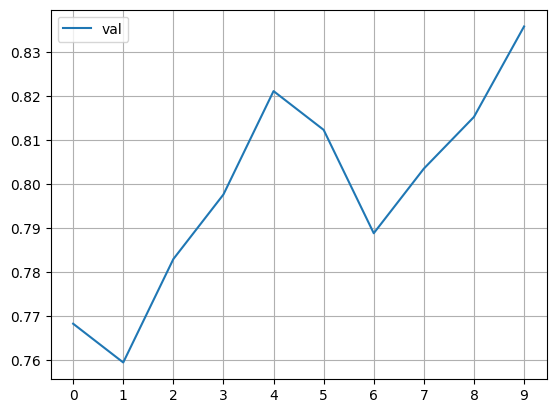

In [83]:
#plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.grid()
plt.legend()

## 8.6 Adjusting the learning rate

    * What's the learning rate
    * Trying different values

In [84]:
# Learning rate is how fast you can read

In [85]:
def  make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet', 
        include_top=False,  
        input_shape=(150, 150, 3)
    )
    
    base_model.trainable = False
    #==================
    
    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    #====================
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True) #the lower the better
    
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model


In [86]:
scores ={}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(f"Learning rate: {lr}")
    
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs= 10, validation_data=val_ds)
    scores[lr] = history.history
    print()
    print()

Learning rate: 0.0001
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 335ms/step - accuracy: 0.2440 - loss: 2.1462 - val_accuracy: 0.5044 - val_loss: 1.6028
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 330ms/step - accuracy: 0.5619 - loss: 1.4305 - val_accuracy: 0.5894 - val_loss: 1.2550
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 319ms/step - accuracy: 0.6479 - loss: 1.1695 - val_accuracy: 0.6628 - val_loss: 1.0757
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 327ms/step - accuracy: 0.6566 - loss: 1.0676 - val_accuracy: 0.7185 - val_loss: 0.9667
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 341ms/step - accuracy: 0.7191 - loss: 0.9039 - val_accuracy: 0.7478 - val_loss: 0.8920
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 340ms/step - accuracy: 0.7271 - loss: 0.8547 - val_accuracy: 0.7419 - val_loss: 0.8419
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 336ms/step - accuracy: 0.7471 - loss: 0.8126 - val_accuracy: 0.7507 - val_loss: 0.8002
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 322ms/step - accuracy: 0.7569 - l

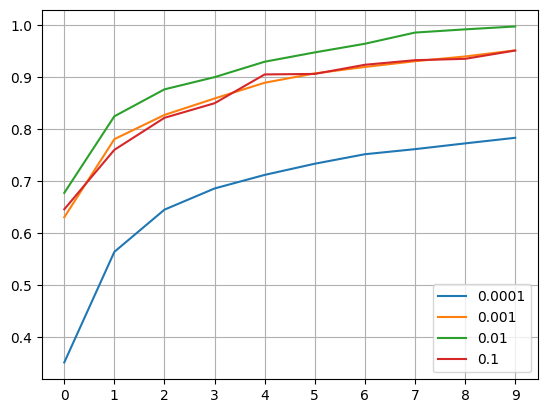

In [89]:
for lr, hist in scores.items():
    #plt.plot(history.history['accuracy'], label = 'train')
    plt.plot(hist['accuracy'], label=lr)


plt.xticks(np.arange(10))
plt.grid()
plt.legend()

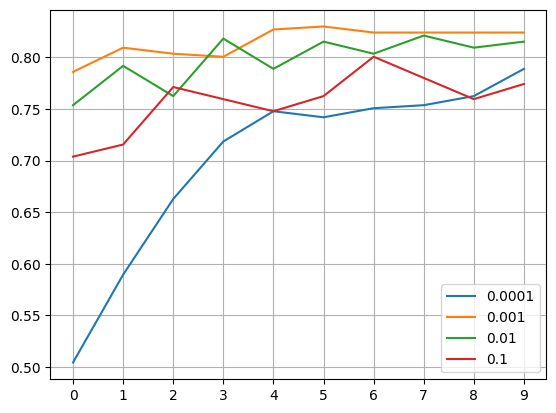

In [91]:
#looking at validation

for lr, hist in scores.items():
    #plt.plot(history.history['accuracy'], label = 'train')
    plt.plot(hist['val_accuracy'], label=lr)


plt.xticks(np.arange(10))
plt.grid()
plt.legend()

In [92]:
# we will remove bad performance and replot
del scores[0.1]
del scores[0.0001]

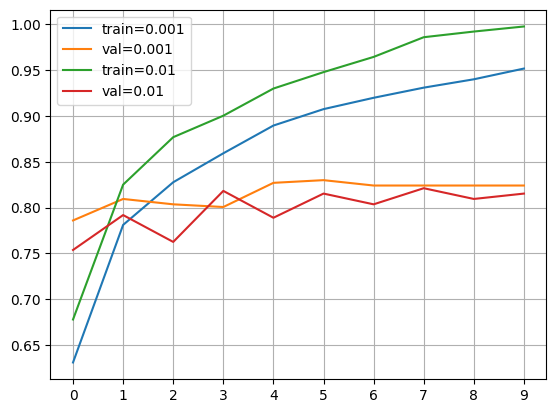

In [94]:
#looking at validation

for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label = f'train={lr}')
    plt.plot(hist['val_accuracy'], label=f'val={lr}')


plt.xticks(np.arange(10))
plt.grid()
plt.legend()


In [ ]:
#Learning rate should be 0.001 since it performs better! b/c the distance between train and val (vertically) is smaller in 0.001

In [95]:
learning_rate = 0.001

## 8.7 Checkpointing

    * Saving the best model only
    * Training a model with callbacks